In [1]:
# Load data science packages
import numpy as np
import pandas as pd

# Load argument packages
import argparse
import re

# Load chemistry packages
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import PandasTools
from rdkit import RDLogger                                                                                                                                                               

RDLogger.DisableLog('rdApp.*')
PandasTools.RenderImagesInAllDataFrames(images=True)

# Load visualization package and display settings
import matplotlib.pyplot as plt
IPythonConsole.molSize = (1000, 300)   # Change image size
IPythonConsole.ipython_useSVG = False  # Show as PNG

class NotCanonicalizableSmilesException(ValueError):
    pass

def canonicalize_smi(smi: str, remove_atom_mapping=False, individual=False) -> str:
    """ Convert a SMILES string into its canonicalized form
    Args:
        smi: Reaction SMILES
        remove_atom_mapping: If True, remove atom mapping information from the canonicalized SMILES output
    Returns:
        SMILES reaction, canonicalized, as a string
    """
    mol = Chem.MolFromSmiles(smi)
    if not mol:
        if individual == False:
            return smi
        elif individual == True:
            return
        else:
            print("Error: individual must be True or False")
    if remove_atom_mapping:
        for atom in mol.GetAtoms():
            if atom.HasProp("molAtomMapNumber"):
                atom.ClearProp("molAtomMapNumber")
    return Chem.MolToSmiles(mol)

def canonicalize_reagents(reagents_list):
    canon_reagents_list = []
    for reagents in reagents_list:
        canon_reagents_list.append('.'.join([canonicalize_smi(reagent) for reagent in reagents.split('.')]))
    
    return canon_reagents_list
        
# Paths
PATH      = '/home/fjaume/MolecularTransformer/'
PATH_tgt  = PATH + 'data/MIT_reagent_pred/tgt-test.txt'
PATH_pred = PATH + 'experiments/results/predictions_MIT_reagent_pred_model_average_20_on_MIT_reagent_pred_test.txt'
PATH_train  = PATH + 'data/MIT_reagent_pred/tgt-train.txt'

# Load data
tgt   = canonicalize_reagents(pd.read_csv(PATH_tgt, header=None).replace('\s+', '', regex=True).values.flatten().tolist())
pred  = canonicalize_reagents(pd.read_csv(PATH_pred, header=None).replace('\s+', '', regex=True).values.flatten().tolist())
train = canonicalize_reagents(pd.read_csv(PATH_train, header=None).replace('\s+', '', regex=True).values.flatten().tolist())

# Calculate accuracy
accuracy = []
for n in range(len(tgt)):
    
    reagents_tgt  = set(tgt[n].split('.'))
    reagents_pred = set(pred[n].split('.'))
    
    accuracy.append(len([reagent for reagent in reagents_pred if reagent in reagents_tgt]) / len(set(tgt[n].split('.'))))

accuracy = 100*np.array(accuracy)
reagent_num = np.array([len(n.split('.')) for n in tgt])

correc_preds = np.array(pred)[np.argwhere(accuracy == 100)].flatten()
correc_tgt = np.array(tgt)[np.argwhere(accuracy == 100)].flatten()

reagents_in_tgt   = sorted(set('.'.join(tgt).split('.')))
reagents_in_pred  = [canonicalize_smi(reagent, individual=True) for reagent in sorted(set('.'.join(pred).split('.')))]
reagents_in_train = sorted(set('.'.join(train).split('.')))
reagents_not_predicted = [reagent for reagent in reagents_in_tgt if reagent not in reagents_in_pred]
reagents_not_in_tgt = [reagent for reagent in reagents_in_pred if reagent not in reagents_in_tgt]
reagents_predicted = [reagent for reagent in reagents_in_tgt if reagent in reagents_in_pred]

train_in_pred = [] 
appearances=[]
predicted=[]
not_pred=[]
totpred=[]
a = [r_tgt.split('.') for r_tgt in tgt]
b = [r_pred.split('.') for r_pred in pred]
c = [r_train.split('.') for r_train in train]

for reagent in reagents_predicted:
    appearances.append(len([n for n in a if reagent in n]))
    predicted.append(len([n for i,n in enumerate(a) if reagent in n and reagent in b[i]]))
    not_pred.append(len([n for i,n in enumerate(a) if reagent in n and reagent not in b[i]]))
    totpred.append(len([n for n in b if reagent in n]))
    train_in_pred.append(len([n for n in c if reagent in n]))
appearances = np.array(appearances)
predicted = np.array(predicted)
totpred = np.array(totpred)
not_pred = np.array(not_pred)
rdmol = [Chem.MolFromSmiles(reagent) for reagent in reagents_predicted]

Tp_element = predicted
Fp_element = (totpred - predicted) / totpred
Fn_element = not_pred

P_element  = Tp_element / (Tp_element + Fp_element) 
R_element  = Tp_element / (Tp_element + Fn_element)
F1_element = 2 * P_element * R_element / (P_element + R_element)

d = {'reagent':reagents_predicted, 'total_tgt':appearances,
     'total_pred':totpred, 'total_train':train_in_pred,
     'correct_pred':predicted, 'precision':P_element,
     'recall':R_element, 'F1':F1_element, 'rdmol':rdmol}
df = pd.DataFrame(data=d)

/tmp/ipykernel_3559933/3492090094.py:117: RuntimeWarning: invalid value encountered in true_divide
  F1_element = 2 * P_element * R_element / (P_element + R_element)


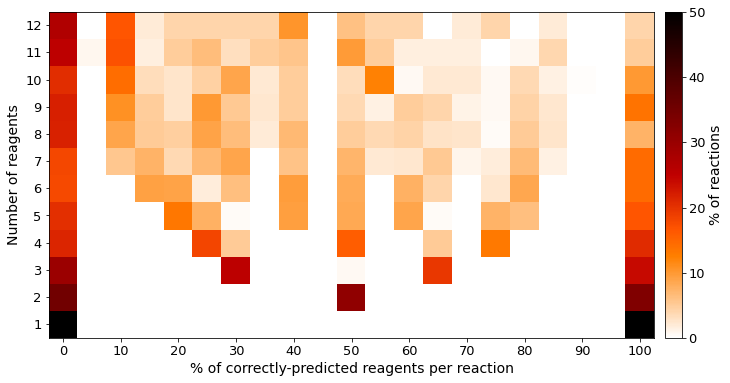

In [369]:
count_reagents_grid = np.empty((12,21))

for n in range(1,13):
    a = np.histogram(accuracy[np.argwhere(reagent_num == n).flatten()], bins=np.arange(0,110,5))[0]
    count_reagents_grid[n-1] = 100 * a / np.sum(a)

# Figure 1. Correcly-predicted reagents per reaction
fig = plt.figure(figsize=(13,6))
ax = plt.subplot(111)
pc = ax.pcolormesh(count_reagents_grid, cmap='gist_heat_r')
ax.set_xlabel('% of correctly-predicted reagents per reaction', fontsize=14)
ax.set_ylabel('Number of reagents', fontsize=14)
ax.set_xticks(np.linspace(.5,20.5,11))
ax.set_xticklabels([0,10,20,30,40,50,60,70,80,90,100])
ax.set_yticks(np.linspace(.5,11.5,12))
ax.set_yticklabels([1,2,3,4,5,6,7,8,9,10,11,12])
cbar = fig.colorbar(pc, pad=0.015)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_ylabel('% of reactions', size=14, rotation=90)
ax.tick_params(labelsize=13)
# plt.savefig('../figs/fig4.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('../figs/fig4.png', dpi=300, bbox_inches='tight')

plt.show()


In [146]:
#df.to_pickle('../experiments/results/reagents_stats.pkl')

In [2]:
i=7088
print('Target:\t\t%s\nPrediction:\t%s'%(correc_tgt[i], correc_preds[i]))

Target:		C1CCOC1.[Br-]
Prediction:	C1CCOC1.[Br-]


In [264]:
import matplotlib.gridspec as gridspec


In [302]:
ax.get_position()

Bbox([[0.0, 0.0], [100.0, 10.0]])

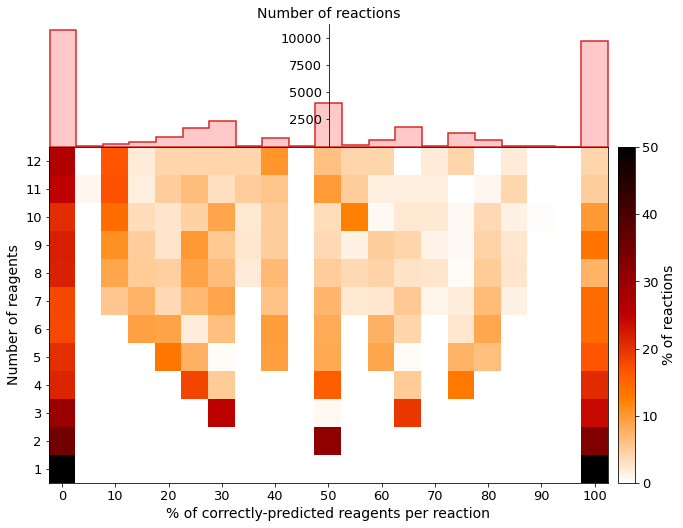

In [370]:
# Figure 1. Correcly-predicted reagents per reaction
fig = plt.figure(figsize=(12,8.5))
gs = fig.add_gridspec(2, 1, height_ratios=[1.5,4])
ax = fig.add_subplot(gs[0, 0])
ax.hist(accuracy, bins=np.arange(0,110,5), align='left', edgecolor='C3',
        color='#FFC9C9', linewidth=1.5, histtype='stepfilled')
#ax.axis("off")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.spines['left'].set_position('center')
#ax.set_xlabel('% of correctly-predicted reagents per reaction', fontsize=14)
#ax.set_ylabel('Number of reactions', fontsize=14)
ax.set_yticks([2500,5000,7500,10000])
ax.tick_params(labelsize=13)

ax2 = fig.add_subplot(gs[1, 0])
pc = ax2.pcolormesh(count_reagents_grid, cmap='gist_heat_r')
ax2.set_xlabel('% of correctly-predicted reagents per reaction', fontsize=14, )
ax2.set_ylabel('Number of reagents', fontsize=14)
ax2.set_xticks(np.linspace(.5,20.5,11))
ax2.set_xticklabels([0,10,20,30,40,50,60,70,80,90,100])
ax2.set_yticks(np.linspace(.5,11.5,12))
ax2.set_yticklabels([1,2,3,4,5,6,7,8,9,10,11,12])
cbar = fig.colorbar(pc, pad=0.015)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_ylabel('% of reactions', size=14, rotation=90)
ax2.tick_params(labelsize=13)

plt.subplots_adjust(hspace=0)
# [left, bottom, width, height]
ax.set_position([.09365, .6745, 0.711, .2])
ax.set_title('Number of reactions', fontsize=14)

plt.savefig('../figs/fig4.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../figs/fig4.png', dpi=300, bbox_inches='tight')

plt.show()

In [4]:
print('From %d (%d) reagents in test (train) reactions, only %d are in the model vocabulary (%.1f%%)'%(len(reagents_in_tgt), len(reagents_in_train), len(reagents_predicted), 100*len(reagents_predicted)/len(reagents_in_tgt),))

From 2457 (12010) reagents in test (train) reactions, only 785 are in the model vocabulary (31.9%)


In [2]:
false_reagents = [reagent for reagent in set('.'.join(pred).split('.')) if reagent not in reagents_in_train]

num_reagents_in_reactions = [len(reaction.split('.')) for reaction in tgt]
num_reagents_in_reactions_train = [len(reaction.split('.')) for reaction in train]

idx_by_num_reagents = [np.argwhere(np.array(num_reagents_in_reactions) == n).flatten() for n in sorted(set(num_reagents_in_reactions))]
idx_by_num_reagents_train = [np.argwhere(np.array(num_reagents_in_reactions_train) == n).flatten() for n in sorted(set(num_reagents_in_reactions_train))]

num_diff_reagents=np.array([len(set('.'.join(np.array(tgt)[n]).split('.'))) for n in idx_by_num_reagents])
num_diff_reagents_train=np.array([len(set('.'.join(np.array(train)[n]).split('.'))) for n in idx_by_num_reagents_train])

r_count = np.array([len(np.argwhere(np.array(num_reagents_in_reactions)==num)) for num in sorted(set(num_reagents_in_reactions))])
r_count_train = np.array([len(np.argwhere(np.array(num_reagents_in_reactions_train)==num)) for num in sorted(set(num_reagents_in_reactions_train))])

acc_per_reagent = [accuracy[num].mean()/100 for num in idx_by_num_reagents]

Tp = []
Fn = []
Fp = []
a = [r_tgt.split('.') for r_tgt in tgt]
b = [r_pred.split('.') for r_pred in pred]

for ireaction, reaction in enumerate(a):
    Tp.append(len([reagent for reagent in reaction if reagent in b[ireaction]]))
    Fn.append(len([reagent for reagent in reaction if reagent not in b[ireaction]]))
    Fp.append(len([reagent for reagent in b[ireaction] if reagent not in reaction]))

Tp = np.array(Tp)
Fn = np.array(Fn)
Fp = np.array(Fp)

P  = np.array([Tp[n].sum() / (Tp[n].sum() + Fp[n].sum()) for n in idx_by_num_reagents])
R  = np.array([Tp[n].sum() / (Tp[n].sum() + Fn[n].sum()) for n in idx_by_num_reagents])
F1 = 2 * P * R / (P + R)

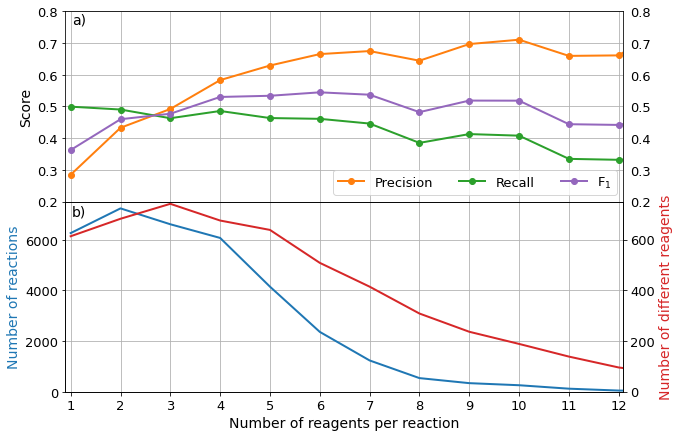

In [11]:
fig = plt.figure(figsize=(10,7))
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)

ax = plt.subplot(gs[0])
plt.plot(sorted(set(num_reagents_in_reactions)), P, 'o-', color='C1', lw=2, zorder=5, label=r'Precision')
plt.plot(sorted(set(num_reagents_in_reactions)), R, 'o-', color='C2', lw=2, zorder=5, label=r'Recall')
plt.plot(sorted(set(num_reagents_in_reactions)), F1, 'o-', color='C4', lw=2, zorder=5, label=r'F$\mathrm{_1}$')
# plt.plot(sorted(set(num_reagents_in_reactions)), acc_per_reagent, 'o-', color='C5', lw=2, zorder=5, label=r'Accuracy')

#ax.set_xlabel('Number of reagents', fontsize=12)
ax.set_ylabel(r'Score', fontsize=14)
ax.tick_params(labelsize=13, labelbottom=False, labelright=True)
plt.ylim(0.2,.8)
ax.set_xticks(sorted(set(num_reagents_in_reactions)))
ax.text(1.02,.76, 'a)', fontsize=14)
ax.set_xlim(.89,12.09)
plt.legend(ncol=3, loc=4, fontsize=13)
plt.grid()

ax2 = plt.subplot(gs[1])
ax2.plot(sorted(set(num_reagents_in_reactions)), r_count, lw=2)
# ax2.fill_between(sorted(set(num_reagents_in_reactions)), 0, r_count, alpha=.3)
ax2.set_xlabel('Number of reagents per reaction', fontsize=14)
ax2.set_ylabel('Number of reactions', fontsize=14, color='C0')
ax2.tick_params(labelsize=13)
ax2.set_xlim(.89,12.09)
plt.ylim(-1,7500)
ax2.text(1.02,6956, 'b)', fontsize=14)
ax2.set_xticks(sorted(set(num_reagents_in_reactions)))
plt.grid()

ax3 = ax2.twinx()
ax3.plot(sorted(set(num_reagents_in_reactions)), num_diff_reagents, color='C3', lw=2)
ax3.set_ylabel('Number of different reagents', fontsize=14, color='C3')
ax3.tick_params(labelsize=13)
ax3.set_ylim((-1,750))
ax3.set_xlim(.89,12.09)


plt.savefig('../figs/fig5.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../figs/fig5.png', dpi=300, bbox_inches='tight')
plt.show()

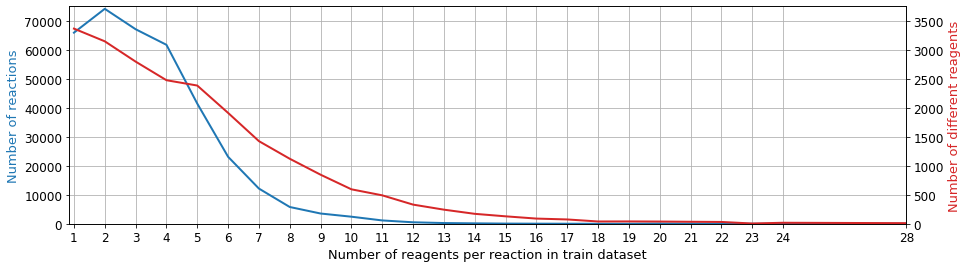

In [103]:
fig = plt.figure(figsize=(15,4))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)

ax= plt.subplot(gs[0])
ax.plot(sorted(set(num_reagents_in_reactions_train)), r_count_train, lw=2)
ax.set_xlabel('Number of reagents per reaction in train dataset', fontsize=13)
ax.set_ylabel('Number of reactions', fontsize=13, color='C0')
ax.tick_params(labelsize=12)
plt.xlim(.85,21.15)
plt.ylim(-1,75000)
ax.set_xticks(sorted(set(num_reagents_in_reactions_train)))
plt.grid()

ax2 = ax.twinx()
ax2.plot(sorted(set(num_reagents_in_reactions_train)), num_diff_reagents_train, color='C3', lw=2)
ax2.set_ylabel('Number of different reagents', fontsize=13, color='C3')
ax2.tick_params(labelsize=12)
ax2.set_ylim((-1,3750))
# ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

# plt.savefig('../figs/Figure_reagent_scores_train.pdf', dpi=300, bbox_inches='tight')
plt.show()

,reagent,total_tgt,total_pred,total_train,correct_pred,precision,recall,F1,rdmol
373,Cc1c(CCO)sc[n+]1Cc1ccccc1,4,4,54,4,1.0,1.0,1.0,

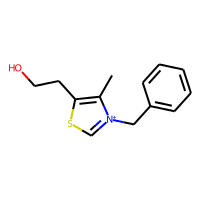

In [4]:
df.sort_values(['F1', 'total_train'], ascending=[False, False]).head(1)

In [ ]:
fig = plt.figure(figsize=(15,4))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)

ax= plt.subplot(gs[0])
ax.plot(sorted(set(num_reagents_in_reactions_train)), r_count_train, lw=2)
ax.set_xlabel('Number of reagents per reaction in train dataset', fontsize=13)
ax.set_ylabel('Number of reactions', fontsize=13, color='C0')
ax.tick_params(labelsize=12)
plt.xlim(.85,21.15)
plt.ylim(-1,75000)
ax.set_xticks(sorted(set(num_reagents_in_reactions_train)))
plt.grid()

ax2 = ax.twinx()
ax2.plot(sorted(set(num_reagents_in_reactions_train)), num_diff_reagents_train, color='C3', lw=2)
ax2.set_ylabel('Number of different reagents', fontsize=13, color='C3')
ax2.tick_params(labelsize=12)
ax2.set_ylim((-1,3750))
# ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

# plt.savefig('../figs/Figure_reagent_scores_train.pdf', dpi=300, bbox_inches='tight')
plt.show()

,reagent,total_tgt,total_pred,total_train,correct_pred,precision,recall,F1,rdmol
614,O=[N+]([O-])C=Cc1ccc(Cl)s1,1,1,0,1,1.0,1.0,1.0,
650,OCc1ccc(OCc2ccc(F)cc2F)cc1,1,1,0,1,1.0,1.0,1.0,

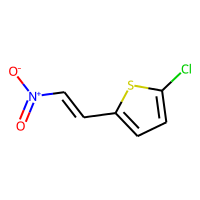
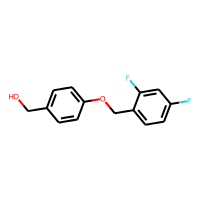

In [5]:
df[df.total_train==0].sort_values(['correct_pred'], ascending=False).head(2)

,reagent,total_tgt,total_pred,total_train,correct_pred,precision,recall,F1,rdmol
0,B,160,155,1795,61,0.990156,0.381250,0.550525,
1,B1C2CCCC1CCC2,14,11,158,5,0.901639,0.357143,0.511628,
2,Br,255,216,2558,109,0.995476,0.427451,0.598087,
3,BrB(Br)Br,186,255,1990,142,0.996889,0.763441,0.864685,
4,BrBr,1,1,27,0,0.000000,0.000000,NaN,
...,...,...,...,...,...,...,...,...,...
780,c1ccsc1,12,2,90,0,0.000000,0.000000,NaN,
781,c1cn[nH]c1,3,1,18,1,1.000000,0.333333,0.500000,
782,c1cnc2c(c1)ccc1cccnc12,5,3,70,1,0.600000,0.200000,0.300000,
783,c1coc(P(c2ccco2)c2ccco2)c1,5,7,67,3,0.840000,0.600000,0.700000,

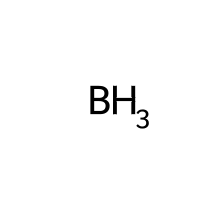
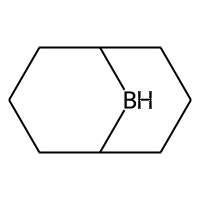
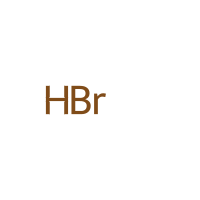
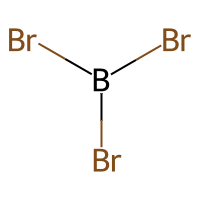
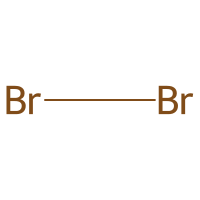
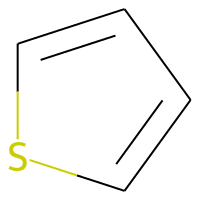
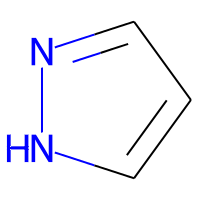
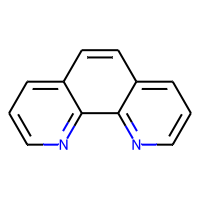
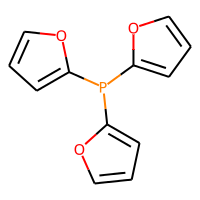
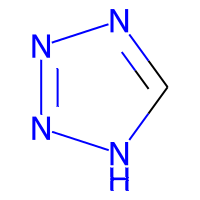

In [6]:
df

In [61]:
df_src = pd.read_csv(PATH + 'data/MIT_reagent_pred/src-test.txt', header=None).replace('\s+', '', regex=True)
df_tgt = pd.read_csv(PATH + 'data/MIT_reagent_pred/tgt-test.txt', header=None).replace('\s+', '', regex=True)
idx_reac1 = df_tgt[df_tgt.squeeze().str.find('O=[N+]([O-])C=Cc1ccc(Cl)s1')!=-1].index
idx_reac2 = df_tgt[df_tgt.squeeze().str.find('OCc1ccc(OCc2ccc(F)cc2F)cc1')!=-1].index

reaction1 = ".".join(df_src.iloc[idx_reac1].values[0,0].split(".")[:-1]) + '>' + df_tgt.iloc[idx_reac1].values[0,0] + '>' + df_src.iloc[idx_reac1].values[0,0].split(".")[-1]
reaction2 = ".".join(df_src.iloc[idx_reac2].values[0,0].split(".")[:-1]) + '>' + df_tgt.iloc[idx_reac2].values[0,0] + '>' + df_src.iloc[idx_reac2].values[0,0].split(".")[-1]

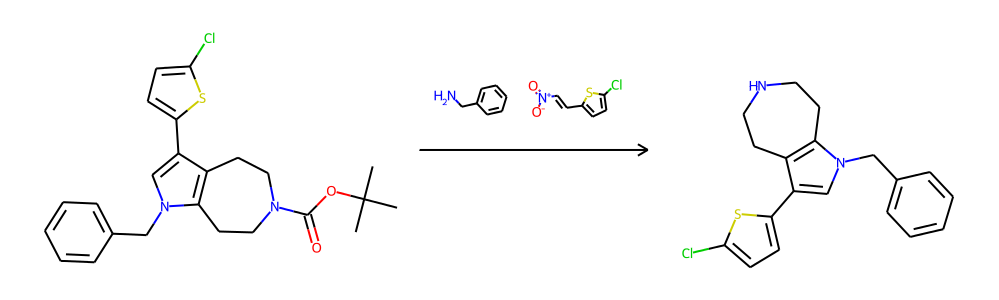

In [60]:
mol1 = AllChem.ReactionFromSmarts(reaction1, useSmiles=True)
mol1

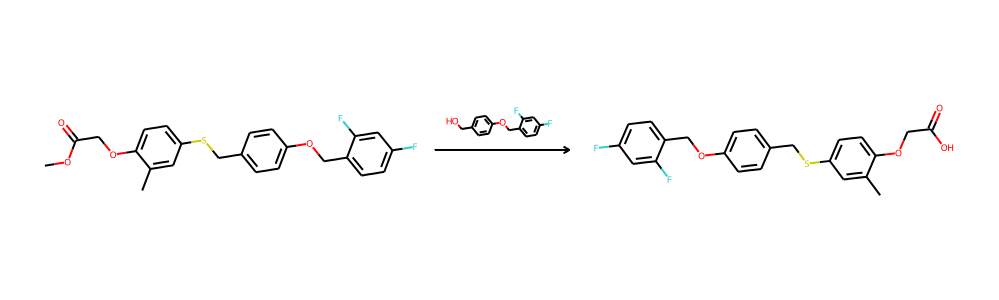

In [62]:
mol2 = AllChem.ReactionFromSmarts(reaction2, useSmiles=True)
mol2